In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import statistics

In [2]:
path = '/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/'

In [3]:
models=['ACCESS-CM2','BCC-CSM2-MR','CanESM5','CESM2','CMCC-CM2-SR5','CMCC-ESM2',\
        'CNRM-CM6-1','CNRM-CM6-1-HR','CNRM-ESM2-1','IITM-ESM','IPSL-CM6A-LR','MIROC6',\
        'MRI-ESM2-0','NorESM2-LM','NorESM2-MM','TaiESM1','EC-Earth3','EC-Earth3-Veg',\
        'EC-Earth3-Veg-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR']
run1 = 'r1i1p1f1'

In [4]:
hist_freq_ens = np.zeros(shape=(21,12))
ssp_freq_ens = np.zeros(shape=(21,12))
dif_ens = np.zeros(shape=(21,12))

n=0
for model in models:
    if model == 'CNRM-CM6-1' or model == 'CNRM-CM6-1-HR' or model == 'CNRM-ESM2-1':
        run2 = 'r1i1p1f2'
        hist_freq = np.load(path+'node_freq_'+model+'_hist_'+run2+'.npy')
        ssp_freq = np.load(path+'node_freq_'+model+'_ssp_'+run2+'.npy')
    else:
        hist_freq = np.load(path+'node_freq_'+model+'_hist_'+run1+'.npy')
        ssp_freq = np.load(path+'node_freq_'+model+'_ssp_'+run1+'.npy')
    dif = ssp_freq - hist_freq

    hist_freq_ens[n] = hist_freq
    ssp_freq_ens[n] = ssp_freq
    dif_ens[n] = dif

    n+=1

In [5]:
data=dif_ens

In [6]:
# Calculate standard deviation for each of the 12 samples
std_dev_per_sample = np.std(data, axis=0)

# Print or use the standard deviations as needed
print("Standard deviation for each of the 12 samples:")
print(std_dev_per_sample)

Standard deviation for each of the 12 samples:
[0.91264261 0.78984175 0.80741164 0.9513958  0.69600945 0.60469904
 0.941688   0.90784525 1.36930897 1.25922307 1.00294657 1.03297827]


In [7]:
# Ratio test to test for significance of node frequency changes
from scipy.stats import ttest_ind

sample1 = hist_freq_ens
sample2 = ssp_freq_ens

pvals = []
# Perform t-test for difference in means
for n in range(0,12):
    # Calculate the ratio of means
    mean_ratio = np.mean(sample1[:,n]) / np.mean(sample2[:,n])
    t_statistic, p_value = ttest_ind(sample1[:,n], sample2[:,n])

    # Define significance level
    alpha = 0.05

    pvals.append(p_value)

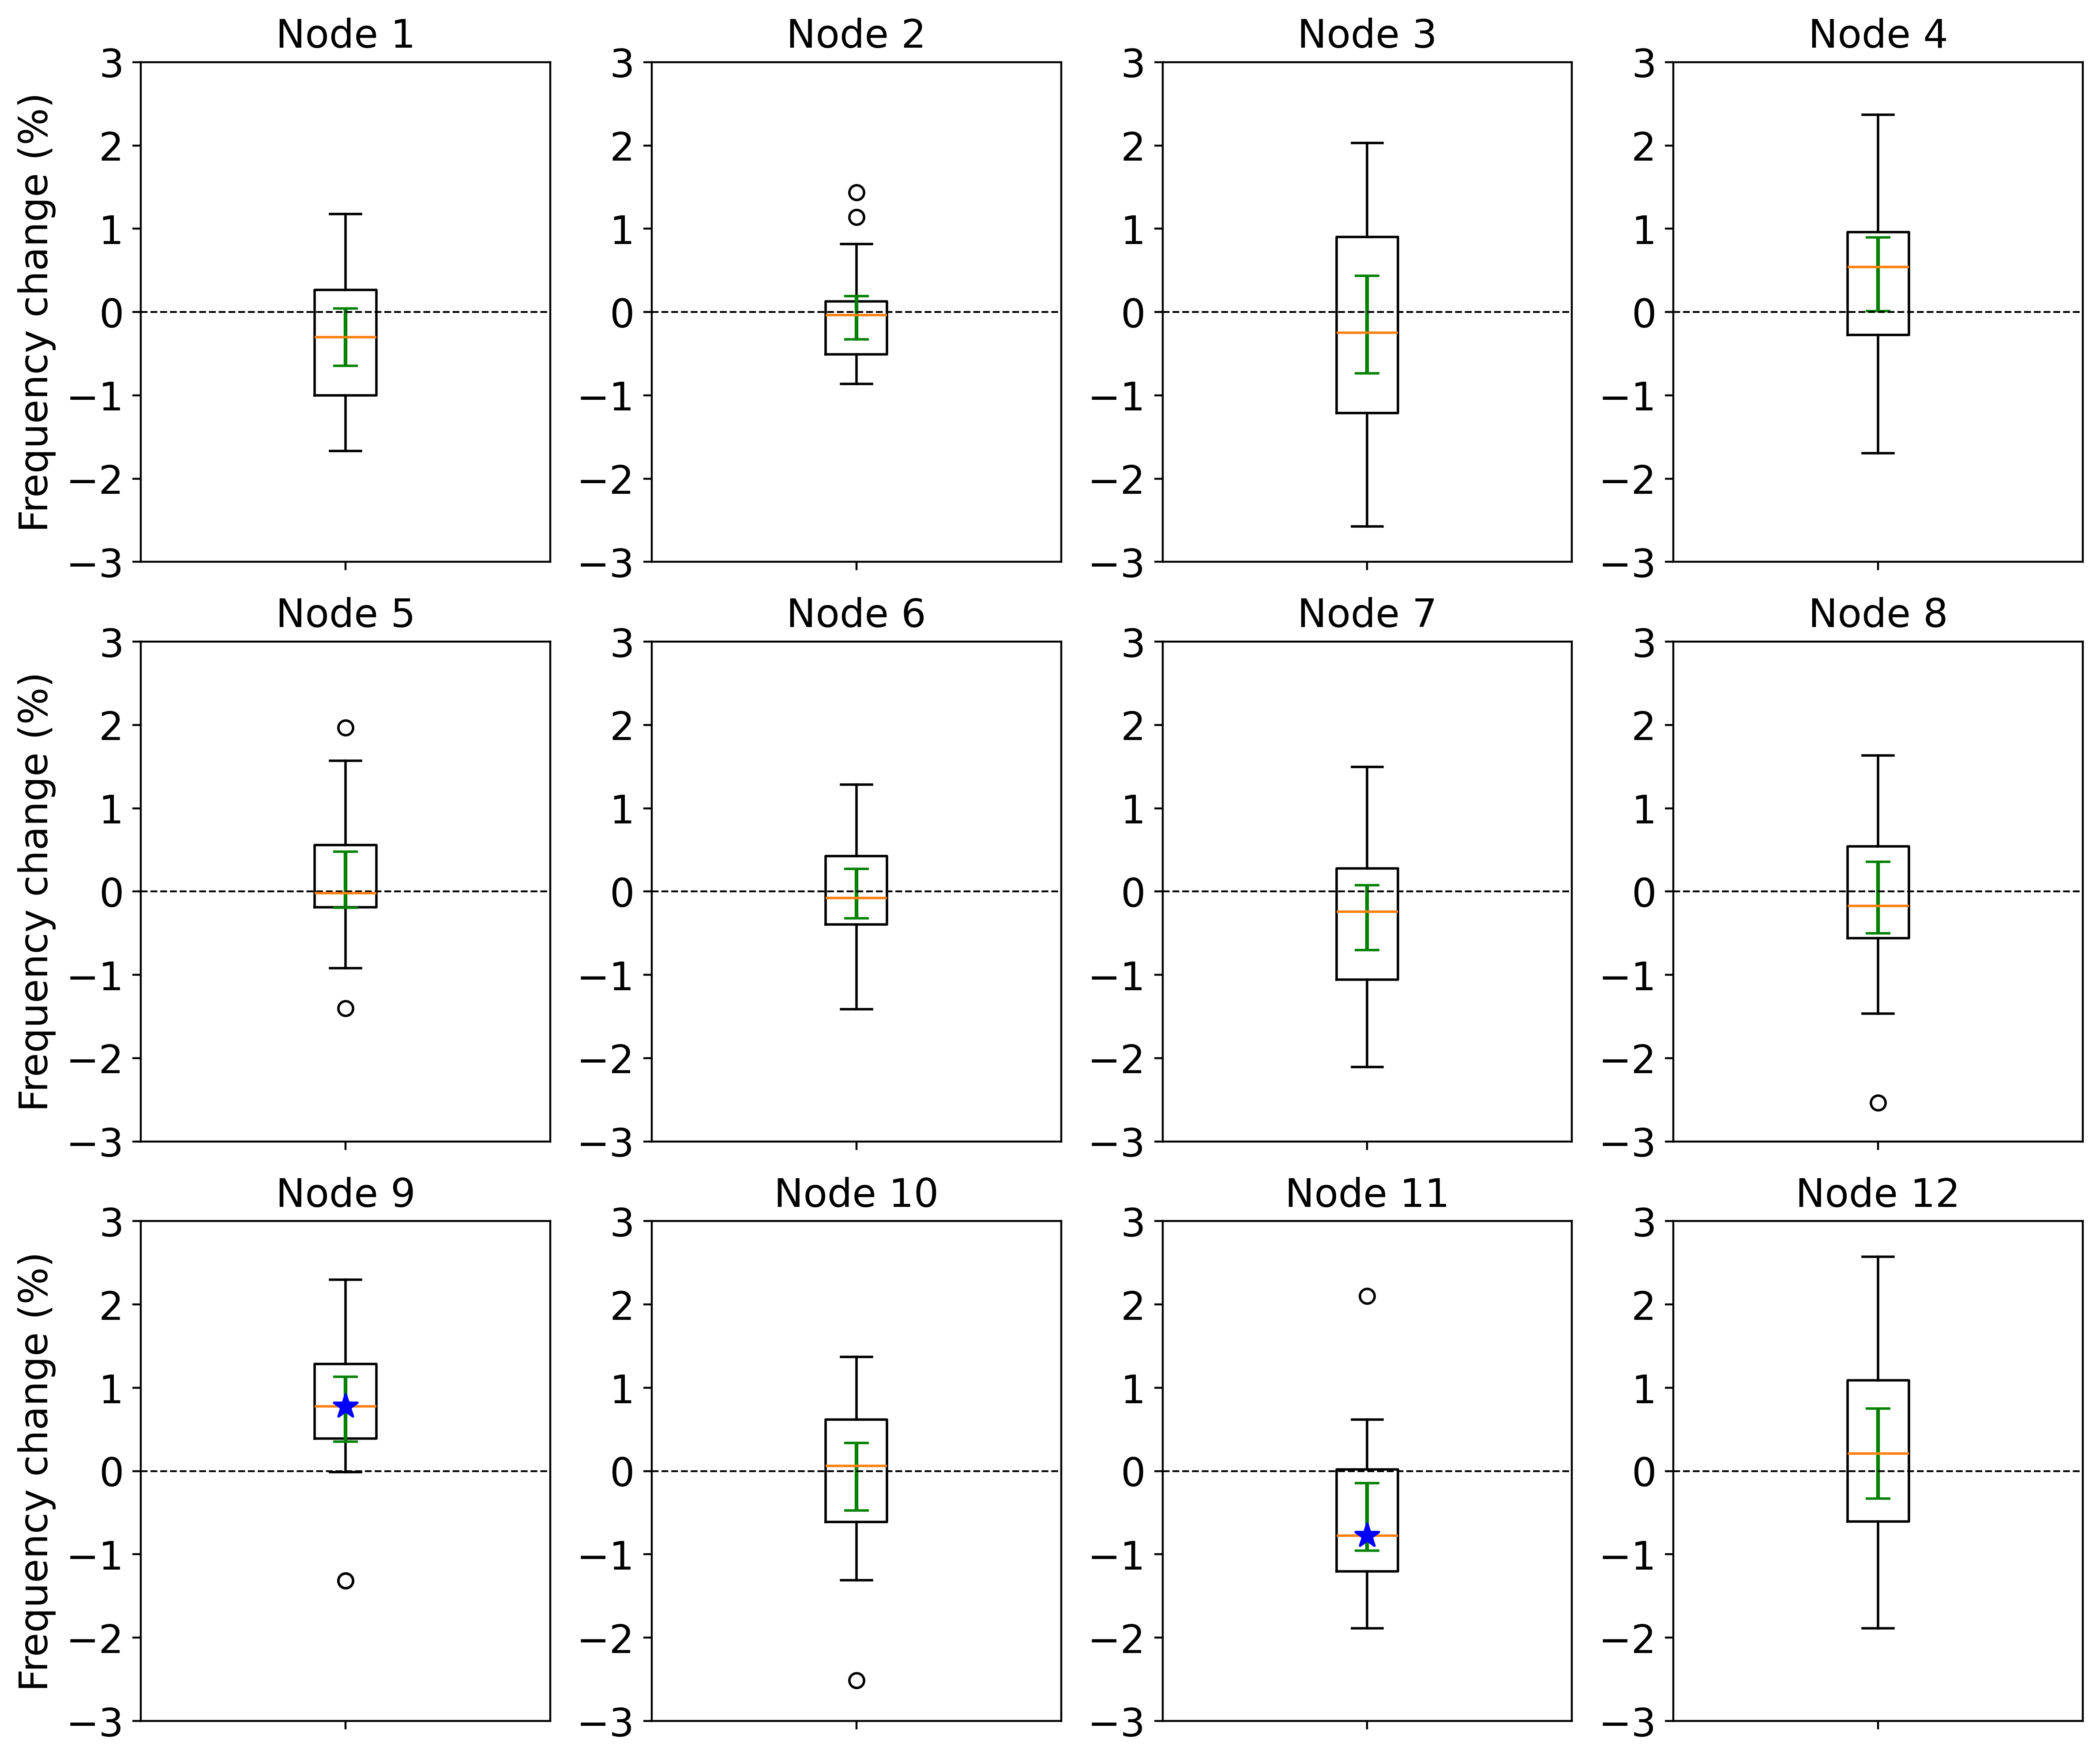

In [8]:
# Define your data and variables
node_list = ['1','2','3','4','5','6','7','8','9','10','11','12']
p_values = pvals
size = 12

# Create a figure with a 3x4 grid layout
fig, axs = plt.subplots(3, 4, figsize=(12, 10), dpi=400)

# Rearrange the subplots
subplot_positions = [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2), (0, 3), (1, 3), (2, 3)]
idx = [2,5,8,11,1,4,7,10,0,3,6,9]

# Plot each boxplot in the rearranged subplot positions
for i, (pos, ax) in enumerate(zip(subplot_positions, axs.flat)):
    y = data[:, idx[i]]
    yerr = std_dev_per_sample[idx[i]]
    
    # Calculate the mean and standard error (SE) of each group
    means = np.mean(y, axis=0)
    std_dev = yerr  # assuming ddof=1 for sample standard deviation
    n = y.shape[0]  # number of samples
    SE = std_dev / np.sqrt(n)

    # Calculate the margin of error (MOE) for 95% CI (assuming normal distribution)
    MOE = 1.96 * SE  # 1.96 is the z-value for 95% confidence interval
    
    # Calculate the upper and lower bounds of the CI
    CI_upper = means + MOE
    CI_lower = means - MOE
    
    # Plot the boxplot with error bars
    boxplot = ax.boxplot(y, tick_labels=[''], whis=1.5)
    ax.errorbar(1, means, yerr=[[means - CI_lower], [CI_upper - means]], fmt='none', color='green', capsize=5)
    
    # Check if the p-value for this column is significant
    if p_values[idx[i]] <= 0.05:  # Adjust significance level as needed
        ax.scatter(1, np.median(y), marker='*', color='blue', s=100, zorder=3)
    
    # Add labels and title
    #ax.set_xlabel(f'Node {node_list[i]}', fontsize=size)
    if i == 0 or i == 4 or i == 8:
        ax.set_ylabel('Frequency change (%)', fontsize=16)
        
    ax.set_title(f'Node {node_list[i]}', fontsize=16)
    ax.set_ylim(-3,3)
    
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.75)
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45, labelsize=size)
    ax.tick_params(axis='y', labelsize=16)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('freq_changes_boxplot_grid_3x4.png')
plt.show()

# Calculate ens mean ua250 (historical)

In [9]:
path1 = '/nfs/data_snow/elisontimm/CMIP6share/'

In [10]:
ua_clim = np.zeros(shape=(21,35,61))

n=0
for model in models:
    if model == 'CNRM-CM6-1' or model == 'CNRM-CM6-1-HR' or model == 'CNRM-ESM2-1':
        run2 = 'r1i1p1f2'
        hist=xr.open_dataset(path1+'historical/'+model+'_historical_r1i1p1f2_ua_NP_regridded_1990_2010_nov_apr_day_lev250.nc')
        ua_hist = hist.ua
    else:
        hist=xr.open_dataset(path1+'historical/'+model+'_historical_r1i1p1f1_ua_NP_regridded_1990_2010_nov_apr_day_lev250.nc')
        ua_hist=hist.ua
        
    ua_clim[n] = ua_hist.mean(axis=0)

    n+=1

In [ ]:
ua_ssp = np.zeros(shape=(21,35,61))

n=0
for model in models:
    if model == 'CNRM-CM6-1' or model == 'CNRM-CM6-1-HR' or model == 'CNRM-ESM2-1':
        run2 = 'r1i1p1f2'
        ssp=xr.open_dataset(path1+'ssp585/'+model+'_ssp585_r1i1p1f2_ua_NP_regridded_2070_2099_nov_apr_day_lev250.nc')
        ua_ssp_ens = ssp.ua
    else:
        ssp=xr.open_dataset(path1+'ssp585/'+model+'_ssp585_r1i1p1f1_ua_NP_regridded_2070_2099_nov_apr_day_lev250.nc')
        ua_ssp_ens=ssp.ua
        
    ua_ssp[n] = ua_ssp_ens.mean(axis=0)

    n+=1

/knight/mamba_aug23/envs/sep24_env/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/knight/mamba_aug23/envs/sep24_env/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/knight/mamba_aug23/envs/sep24_env/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/knight/ma

In [13]:
ua_dif = ua_ssp - ua_clim

In [14]:
std_dev_ua_anom = np.std(ua_dif, axis=0)

In [15]:
ua_ens_dif = ua_dif.mean(axis=0)

In [16]:
# Get lat/lon info and convert to np arrays
lat = hist.lat.values
lon = hist.lon.values

# Calculate ens mean ua anomalies (ssp585-hist

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [18]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_9667/2812379868.py:39: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
/tmp/ipykernel_9667/2812379868.py:39: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
/tmp/ipykernel_9667/2812379868.py:39: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_ytickl

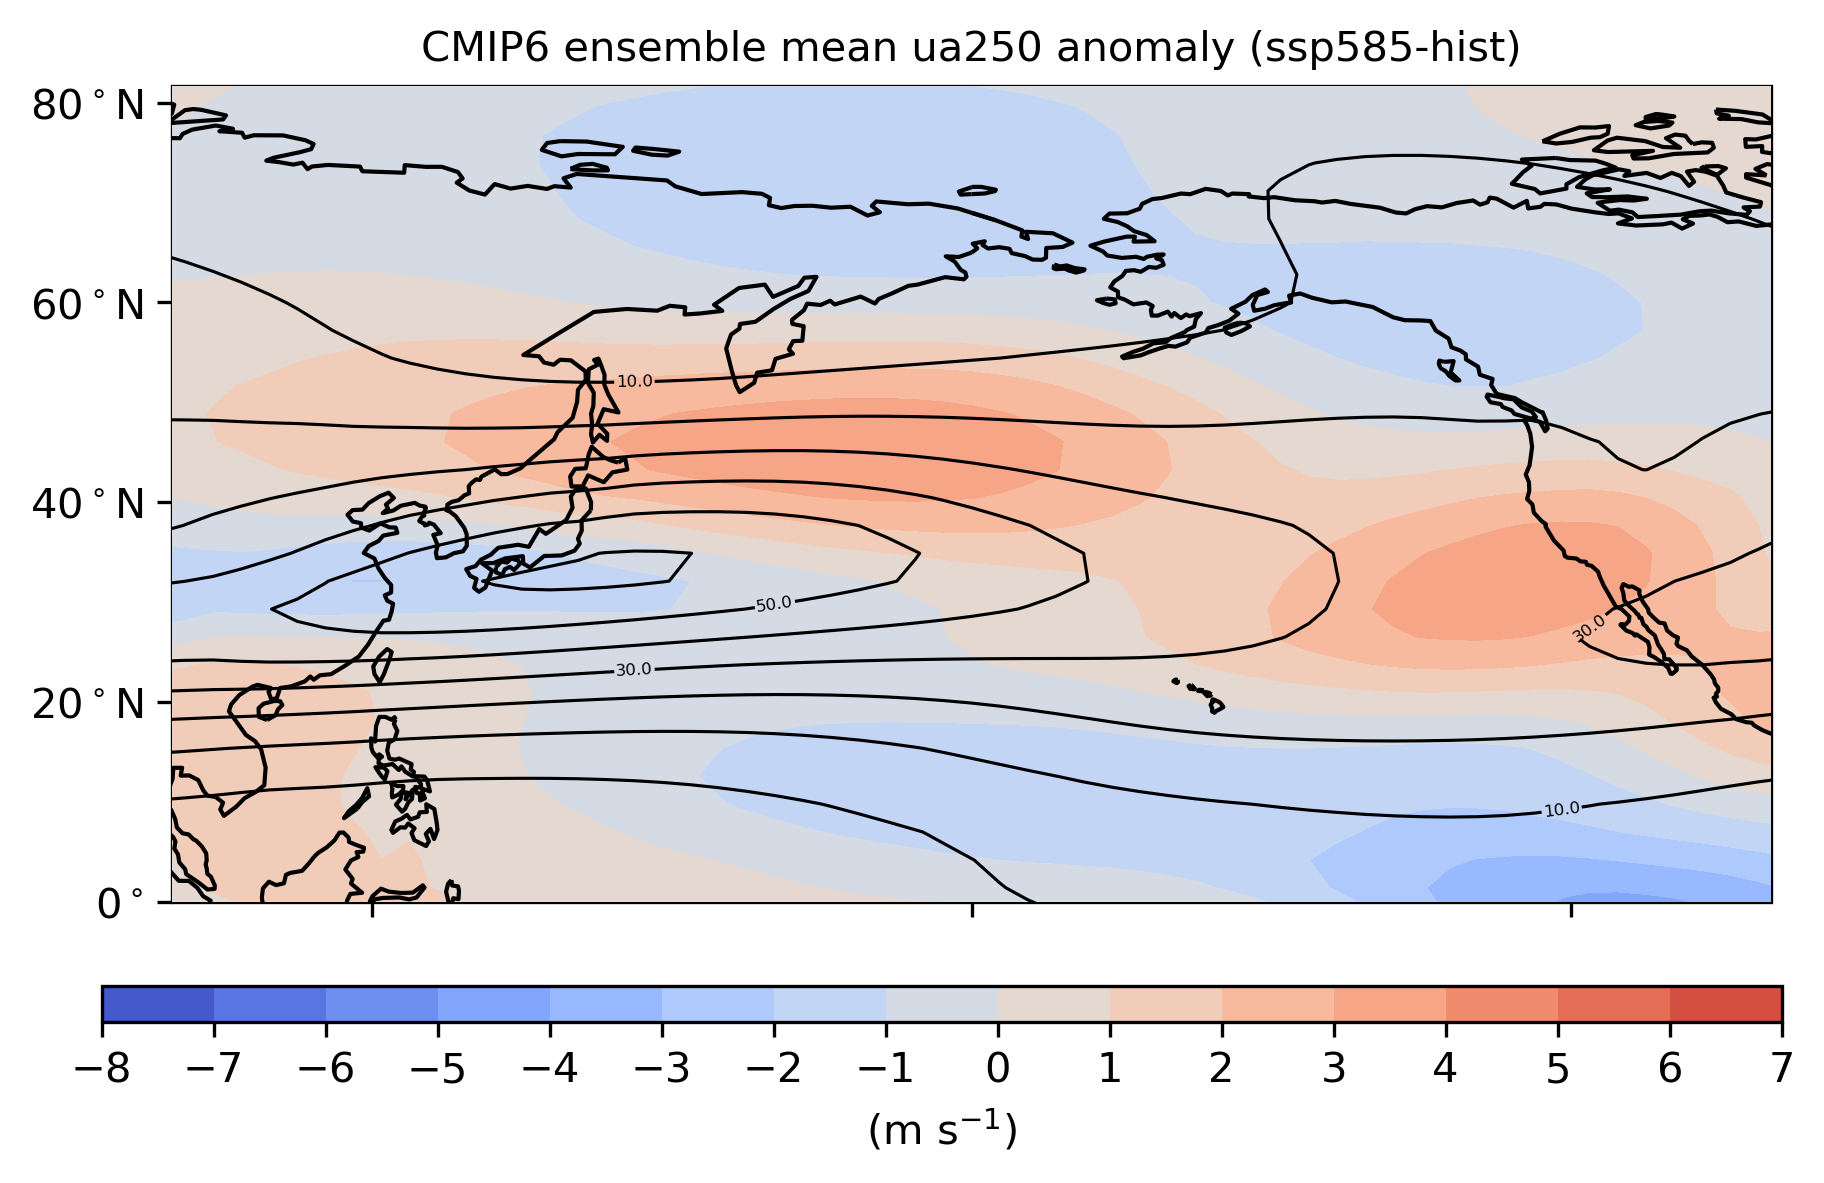

In [21]:
# Make figure
fig = plt.figure(figsize=(8,4), dpi=300)
data_crs = ccrs.PlateCarree()

central_lat = 15
central_lon = 210
extent = [100, 260, 0, 50]

size = 10
vmin = -8
vmax = 8
level = np.arange(vmin,vmax,1)

ax1 = plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax1.set_extent(extent)

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor=cfeature.COLORS['land'])
ocean = cfeature.NaturalEarthFeature(category='physical', name='ocean', scale='50m',
                                    facecolor='gray')

ax1.add_feature(ocean,zorder=1)
ax1.add_feature(land,zorder=2)

ct=ax1.contour(lon,lat,ua_clim.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax1.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax1.contourf(lon,lat,ua_ens_dif,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)


#cbar = fig.colorbar(contf,ax=ax1, shrink=.3)
#cbar.ax.tick_params(labelsize=size)
ax1.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax1.coastlines(zorder=5)
#ax1.set_xlabel("",size=size)
#ax1.set_ylabel("",size=size)
ax1.set_xticks(ticks = np.arange(-90, 60,60))
ax1.set_yticks(ticks = np.arange(0, 85,20))
ax1.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
ax1.set_xticklabels(labels = ['','',''],size = size)
ax1.set_title('CMIP6 ensemble mean ua250 anomaly (ssp585-hist)', size=size)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])
cbar = fig.colorbar(contf, cax=cbar_ax, ticks = np.arange(vmin, vmax, 1), orientation='horizontal', shrink = 0.60, pad = 0.0)
cbar.set_label('(m s$^{-1}$)',fontsize=size)
cbar.ax.tick_params(labelsize=size)

plt.savefig('cmip6_ens_mean_ua250_anom.png')
plt.show()

In [ ]:
# Make figure
fig = plt.figure(figsize=(8,4), dpi=300)
data_crs = ccrs.PlateCarree()

central_lat = 15
central_lon = 210
extent = [100, 260, 0, 50]

size = 10
vmin = -8
vmax = 8
level = np.arange(vmin,vmax,1)

ax1 = plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax1.set_extent(extent)

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor=cfeature.COLORS['land'])
ocean = cfeature.NaturalEarthFeature(category='physical', name='ocean', scale='50m',
                                    facecolor='gray')

ax1.add_feature(ocean,zorder=1)
ax1.add_feature(land,zorder=2)

ct=ax1.contour(lon,lat,std_dev_ua_anom,colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax1.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax1.contourf(lon,lat,ua_ens_dif,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)


#cbar = fig.colorbar(contf,ax=ax1, shrink=.3)
#cbar.ax.tick_params(labelsize=size)
ax1.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax1.coastlines(zorder=5)
#ax1.set_xlabel("",size=size)
#ax1.set_ylabel("",size=size)
ax1.set_xticks(ticks = np.arange(-90, 60,60))
ax1.set_yticks(ticks = np.arange(0, 85,20))
ax1.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
ax1.set_xticklabels(labels = ['','',''],size = size)
ax1.set_title('std dev ua250 anom (ssp585-hist)', size=size)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])
cbar = fig.colorbar(contf, cax=cbar_ax, ticks = np.arange(vmin, vmax, 1), orientation='horizontal', shrink = 0.60, pad = 0.0)
cbar.set_label('(m s$^{-1}$)',fontsize=size)
cbar.ax.tick_params(labelsize=size)

plt.savefig('ua250_std_dev_ens.png')
plt.show()